In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from torchvision import models, transforms, utils
from torchvision.transforms.functional import normalize, resize, to_pil_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
def preprocess_image(image, size=(224, 224)):
    # Open and resize image
    # image = Image.open(image_path)
    image = image.resize(size, Image.Resampling.LANCZOS)
    
    # Convert the image to a numpy array and then to grayscale
    img = np.array(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply a binary threshold to get a binary image
    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

   # Check if contours list is not empty
    if contours:
        # Find the largest contour which should be the fundus
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding rectangle for the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the image to the bounding rectangle
        cropped = image.crop((x, y, x+w, y+h))
    else:
        print(f"No contours found in image")
        cropped = image  # or handle this case differently as per your requirement

    # Resize the cropped image to the desired size
    cropped = cropped.resize(size, Image.Resampling.LANCZOS)

    # # Color normalization
    # mean = np.mean(cropped, axis=(0, 1))
    # image_normalized = cropped - mean

    # Illumination correction and contrast enhancement using CLAHE
    image_lab = cv2.cvtColor(np.uint8(cropped), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(image_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    image_clahe = cv2.merge((l_clahe, a, b))
    image_clahe_rgb = cv2.cvtColor(image_clahe, cv2.COLOR_LAB2RGB)


    # Convert the image to uint8 before applying Gaussian blur
    image_clahe_rgb_uint8 = (image_clahe_rgb * 255).astype(np.uint8)

    # Apply Gaussian blur
    image_denoised = cv2.GaussianBlur(image_clahe_rgb_uint8, (5, 5), 0.5)

    image_denoised = Image.fromarray(image_denoised)
    return image_denoised

In [3]:
def crop_fundus_image(image_path, save_path=None):
    # Load the image
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to get a binary image
    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour which should be the fundus
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image to the bounding rectangle
    cropped_img = img[y:y+h, x:x+w]
    
    # Save or return the cropped image
    if save_path:
        cv2.imwrite(save_path, cropped_img)
    else:
        return cropped_img

In [4]:
def preprocess_all_images(dataset_dirs=['DDR-dataset/DR_grading/train', 'DDR-dataset/DR_grading/valid', 'DDR-dataset/DR_grading/test']):
    for dataset_dir in dataset_dirs:
        image_files = os.listdir(dataset_dir)
        for image_file in image_files:
            image_path = os.path.join(dataset_dir, image_file)
            image = Image.open(image_path)
            preprocessed_image = preprocess_image(image)
            save_path = os.path.join(dataset_dir + '_preprocessed', image_file)
            preprocessed_image.save(save_path)

# preprocess_all_images()

In [5]:
train_df = pd.read_csv('DDR-dataset/DR_grading/train.txt', sep=' ', header=None, names=['image', 'label'])
train_df = train_df.query('label != 5')
train_df['path'] = train_df['image'].apply(lambda x: os.path.join('DDR-dataset/DR_grading/train_preprocessed', x))

In [6]:
val_df = pd.read_csv('DDR-dataset/DR_grading/valid.txt', sep=' ', header=None, names=['image', 'label'])
val_df = val_df.query('label != 5')
val_df['path'] = val_df['image'].apply(lambda x: os.path.join('DDR-dataset/DR_grading/valid_preprocessed', x))

In [7]:
def balance_dataset(df):
    new_rows = []
    class_counts = np.bincount(df['label'])
    difference = np.max(class_counts) - class_counts
    aug_transforms = v2.Compose([
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.RandomRotation(degrees=360),
        v2.RandomPerspective(distortion_scale=0, p=1, interpolation=3),
        v2.RandomAffine(degrees=0, translate=(0, 0), scale=(1, 1), shear=0),
        v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
    ])
    for i, count in enumerate(difference):
        if count > 0:
            samples = df.query(f'label == {i}').sample(count, replace=True)
            # print(len(samples))
            for index, row in samples.iterrows():
                image = Image.open(row['path'])
                augmented_image = aug_transforms(image)
                augmented_image.save(f'{row["path"][:-4]}_augmented{count}.png')
                new_rows.append({'image': f'{row["image"][:-4]}_augmented{count}.png', 'label': i, 'path': f'{row["path"][:-4]}_augmented{count}.png'})
    new_df = pd.DataFrame(new_rows)
    new_df = pd.concat([df, new_df])
    return new_df

# new_df = balance_dataset(train_df)

# new_df.to_csv('DDR-dataset/DR_grading/train_augmented.txt', sep=' ', header=False, index=False)

In [8]:
train_df = pd.read_csv('DDR-dataset/DR_grading/train_augmented.txt', sep=' ', header=None, names=['image', 'label', 'path'])

In [9]:
x_train = train_df['path']
y_train = train_df['label']
x_val = val_df['path']
y_val = val_df['label']

In [10]:
# x_train = train_df['path']

# y_train = pd.get_dummies(train_df['label']).values

# y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
# y_train_multi[:, 4] = y_train[:, 4]

# for i in range(3, -1, -1):
#     y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

# print("Original y_train:", y_train.sum(axis=0))
# print("Multilabel version:", y_train_multi.sum(axis=0))

In [11]:
# x_val = val_df['path']
# y_val = pd.get_dummies(val_df['label']).values
# y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
# y_val_multi[:, 4] = y_val[:, 4]

# for i in range(3, -1, -1):
#     y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

# print("Original y_val:", y_val.sum(axis=0))
# print("Multilabel version:", y_val_multi.sum(axis=0))

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, paths, label, transform=None):
        self.paths = paths
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths.iloc[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.label[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transformations
aug_transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=360),
    v2.RandomPerspective(distortion_scale=0, p=1, interpolation=3),
    v2.RandomAffine(degrees=0, translate=(0, 0), scale=(1, 1), shear=0),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
])

# Define the main transformation pipeline
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomApply([aug_transforms], p=0.5),  # Apply augmentations with 50% probability
    # v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create custom datasets and dataloaders for training and validation
train_dataset = CustomImageDataset(x_train,y_train, transform=transform)
val_dataset = CustomImageDataset(x_val,y_val, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


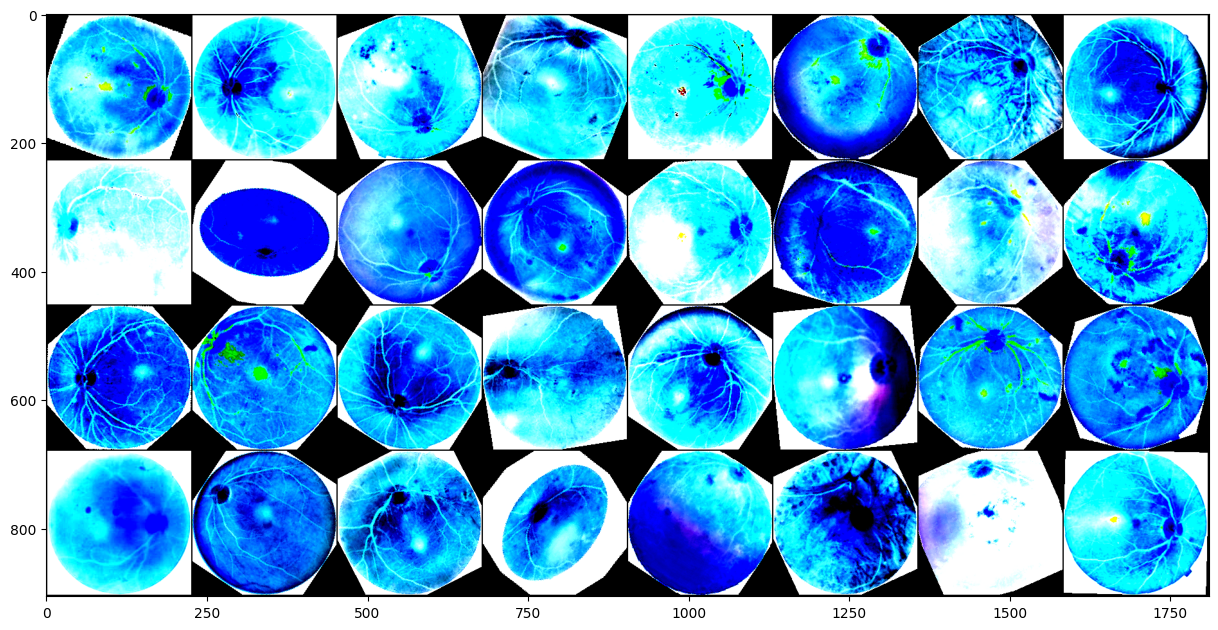

In [13]:

def show_batch(batch):
    images, labels = batch
    grid_img = utils.make_grid(images, nrow=8)
    grid_img = np.transpose(grid_img, (1, 2, 0))
    # print(images.size())
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img)
    plt.show()

# Iterate over the train_dataloader and visualize a batch
for batch in train_dataloader:
    show_batch(batch)
    break  # Stop after visualizing the first batch

In [17]:
from torch.nn.parameter import Parameter
import torch.nn.functional as F
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'


In [18]:
# Load pre-trained ResNet-50
resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the final fully connected layer for your specific classification task
num_classes = 5  # Assuming you have 5 classes
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
   
resnet.avgpool = GeM()

# Define loss function and optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_func = nn.CrossEntropyLoss()

# Move the model to GPU if available
resnet.to(device)

best_acc = 0

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    resnet.train()

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()


    # Validation
    resnet.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            val_loss += loss_func(outputs, labels).item()

            all_preds.append(outputs.cpu().detach().numpy())
            all_labels.append(labels.cpu().detach().numpy())

    val_loss /= len(val_dataloader)
        
    # Flatten predictions and labels for Quadratic Weighted Kappa calculation
    all_preds = np.concatenate(all_preds).argmax(axis=1)
    all_labels = np.concatenate(all_labels)


    # Calculate Quadratic Weighted Kappa
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    
    acc = accuracy_score(all_labels, all_preds)
    if acc > best_acc:
        best_acc = acc
        print('saving model')
        torch.save(resnet.state_dict(), 'DDRresnet50_best_acc.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, QWK: {qwk:.4f}, Acc: {acc:.4f}')

KeyboardInterrupt: 

In [ ]:
# Load the test image
test_image_path = 'train_images/0024cdab0c1e.png'
test_image = Image.open(test_image_path).convert("RGB")

# Define the transformation pipeline for test images
test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply transformations to the test image
test_image = test_transform(test_image)

# If you're using GPU, move the image to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
test_image = test_image.to(device)

# Load the trained model
resnet = models.resnet50(pretrained=True)
num_classes = 5  # Assuming you have 5 classes
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, num_classes),
    nn.Sigmoid()
)
resnet.load_state_dict(torch.load('ResNet50.pth', map_location=device))
resnet.to(device)
resnet.eval()

# Perform inference
with torch.no_grad():
    outputs = resnet(test_image.unsqueeze(0))  # Add a batch dimension

# Convert the output probabilities to predicted labels
predicted_labels = np.round(outputs.cpu().numpy()).astype(int)

print("Predicted labels:", predicted_labels)


In [ ]:
test_image_path = 'train_images/0024cdab0c1e.png'
test_image = Image.open(test_image_path).convert("RGB")

preprocess = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
original_image_preprocess = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])
test_image_tensor = preprocess(test_image)
original_image_tensor = original_image_preprocess(test_image)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
test_image_tensor = test_image_tensor.to(device)
original_image_tensor = original_image_tensor.to(device)

model = models.resnet50(pretrained=True)
num_classes = 5 # Number of predicted classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, num_classes),
    nn.Sigmoid()
)
model.load_state_dict(torch.load('ResNet50.pth', map_location=device))
model.to(device)
model.eval()

last_conv_layer = 'layer4'
cam_extractor = GradCAM(model, last_conv_layer)
out = model(test_image_tensor.unsqueeze(0)) 
predicted_class = int(np.round(out.cpu().detach().numpy()).astype(int).sum() - 1)
cams = cam_extractor(predicted_class, out)


result = overlay_mask(to_pil_image(original_image_tensor), to_pil_image(cams[0].squeeze(0), mode='F'), alpha=0.5) 
plt.imshow(result)
plt.axis('off')
plt.show()

In [ ]:
def get_predicted_label_and_gradcam(image, model, last_conv_layer):
    preprocess = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    original_image_preprocess = v2.Compose([
        v2.Resize((224, 224)),
        v2.ToTensor(),
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    image = image.convert("RGB")
    test_image_tensor = preprocess(image)
    original_image_tensor = original_image_preprocess(image)

    test_image_tensor = test_image_tensor.to(device)
    original_image_tensor = original_image_tensor.to(device)

    model.to(device)
    model.eval()

    cam_extractor = GradCAM(model, last_conv_layer)
    out = model(test_image_tensor.unsqueeze(0)) 
    predicted_class = int(np.round(out.cpu().detach().numpy()).astype(int).sum() - 1)
    cams = cam_extractor(predicted_class, out)

    # resized_gradcam = torch.nn.functional.interpolate(cams[0].unsqueeze(0), size=original_image_tensor.shape[-2:], mode='bilinear', align_corners=False)
    # gradcam_image = overlay_mask(to_pil_image(original_image_tensor), to_pil_image(resized_gradcam.squeeze(0), mode='F'), alpha=0.5)
    gradcam_image = overlay_mask(to_pil_image(original_image_tensor), to_pil_image(cams[0].squeeze(0), mode='F'), alpha=0.5)

    return predicted_class, gradcam_image

In [ ]:
# Example usage:
test_image_path = 'DDR-dataset/DR_grading/train_preprocessed/007-0004-000.jpg'
image = Image.open(test_image_path)

model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_classes = 5 # Number of predicted classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, num_classes),
    nn.Sigmoid()
)
model.load_state_dict(torch.load('ResNet50.pth', map_location=torch.device("mps")))

last_conv_layer = 'layer4'

predicted_label, gradcam_images = get_predicted_label_and_gradcam(image, model, last_conv_layer)

print("Predicted Label:", predicted_label)
plt.imshow(gradcam_images)
plt.axis('off')
plt.show()
